# Access InfluxDB from Python
Inspired by https://www.influxdata.com/blog/getting-started-python-influxdb/

In [1]:
from influxdb import InfluxDBClient
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

In [2]:
# InfluxDB host address and user credentials
host = "192.168.178.63"
username = "influx_user_1"

# This ipython widget input for the password avoids storing the password into the notebook.
display(widgets.Label(f'Enter password for {username=}:'))
pw = widgets.Password(value="password")
display(pw)

Label(value="Enter password for username='influx_user_1':")

Password()

## Make the client and connect to a database

In [3]:
client = InfluxDBClient(host=host, port=8086, username=username, password=pw.value)
client.get_list_database()

[{'name': '_internal'},
 {'name': 'influx_db_1'},
 {'name': 'influx_db_2'},
 {'name': 'influx_db_3'},
 {'name': 'influx_db_4'}]

In [36]:
client.switch_database('influx_db_3')

## show series

In [28]:
for p in client.query("show series").get_points():
    print(p["key"])

%,domain=sensor,entity_id=cooper_se_charging_target
%,domain=sensor,entity_id=cooper_se_remaining_battery_percent
%,domain=sensor,entity_id=ewelink_ds01_battery
%,domain=sensor,entity_id=hp_laserjet_pro_m118_m119_black_cartridge_hp_cf294a
%,domain=sensor,entity_id=hp_laserjet_pro_m118_m119_imaging_drum_hp_cf232a
%,domain=sensor,entity_id=my_sensor
%,domain=sensor,entity_id=openweathermap_cloud_coverage
%,domain=sensor,entity_id=openweathermap_forecast_cloud_coverage
%,domain=sensor,entity_id=openweathermap_forecast_precipitation_probability
%,domain=sensor,entity_id=openweathermap_humidity
%,domain=sensor,entity_id=pixel_6a_battery_level
%,domain=sensor,entity_id=shelly_uni2_humidity
%,domain=sensor,entity_id=shellyuni_34945478fe57_humidity
%,domain=sensor,entity_id=sm_t860_battery_level
%,domain=sensor,entity_id=sma_battery_capacity_total
%,domain=sensor,entity_id=sma_battery_soc_total
%,domain=sensor,entity_id=smoke_detector_battery_level
%,domain=sensor,entity_id=sn_3015663157_batte

## Query data 

In [37]:
qstr = 'SELECT value, entity_id FROM W WHERE TIME >= now() -1m'
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df.tail()

,time,value,entity_id
156,2023-08-09T18:29:55.505901Z,377.00,total_power_consumed
157,2023-08-09T18:29:55.506683Z,11.32,filter_solar_power
158,2023-08-09T18:29:55.507795Z,-7.00,power_exported
159,2023-08-09T18:29:55.515254Z,397.67,filter_total_power_consumed
160,2023-08-09T18:29:55.515774Z,1.68,filter_power_exported


In [38]:
df.time = pd.to_datetime(df.time)
df = df.set_index("time")
df.head()

,value,entity_id
time,,
2023-08-09 18:29:00.471602+00:00,372.0,sma_battery_power_discharge_total
2023-08-09 18:29:00.474906+00:00,380.0,sma_grid_power
2023-08-09 18:29:00.475893+00:00,13.0,sma_pv_power_a
2023-08-09 18:29:00.480243+00:00,8.0,sma_metering_power_supplied
2023-08-09 18:29:00.480835+00:00,43.0,sma_metering_active_power_feed_l1


In [39]:
df.entity_id.value_counts()

entity_id
sma_battery_power_discharge_total    12
sma_pv_power_a                       12
sma_metering_active_power_feed_l1    12
byd_charging_power                   12
total_power_consumed                 12
filter_solar_power                   12
power_exported                       12
filter_total_power_consumed          12
filter_power_exported                12
sma_metering_active_power_feed_l3    11
sma_metering_active_power_draw_l2    11
sma_grid_power                       10
sma_metering_power_supplied          10
sma_metering_power_absorbed           7
sma_metering_active_power_draw_l1     4
Name: count, dtype: int64

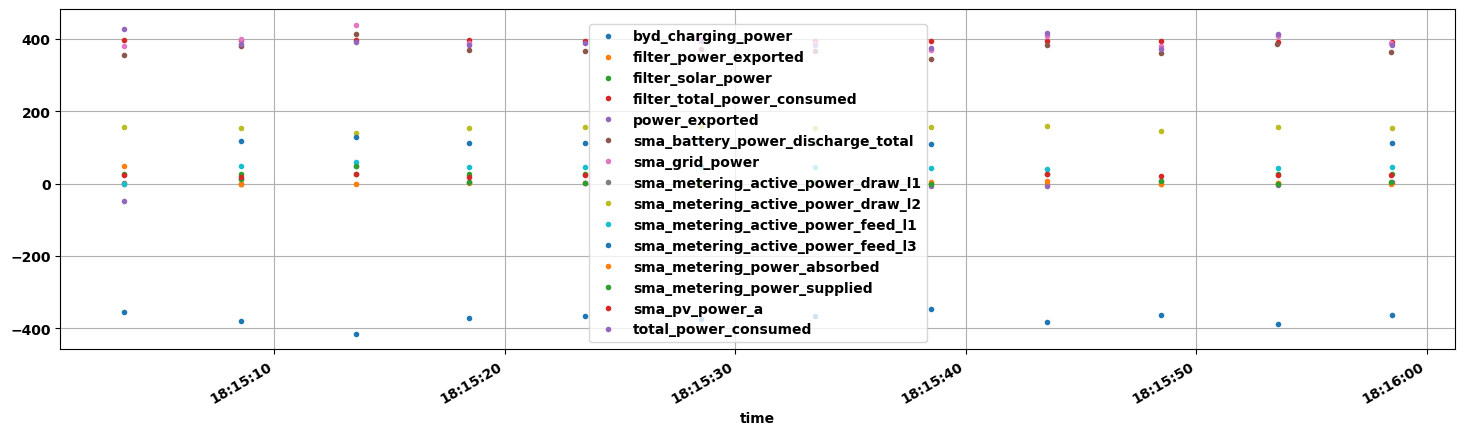

In [17]:
df.groupby('entity_id')['value'].plot(figsize=(18,5), style=".", legend=True, grid="both");

# Show Temperatures form influx_db_4 

In [40]:
client.switch_database('influx_db_4')

In [68]:
qstr = """SELECT mean_value FROM "°C" WHERE entity_id='shelly_uni2_temperature' AND TIME >= now() - 100d"""
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df.time = pd.to_datetime(df.time)
df = df.set_index("time")
df.tail()

,mean_value
time,
2023-08-09 14:00:00+00:00,20.286047
2023-08-09 15:00:00+00:00,18.955357
2023-08-09 16:00:00+00:00,18.476596
2023-08-09 17:00:00+00:00,18.346341
2023-08-09 18:00:00+00:00,17.971951


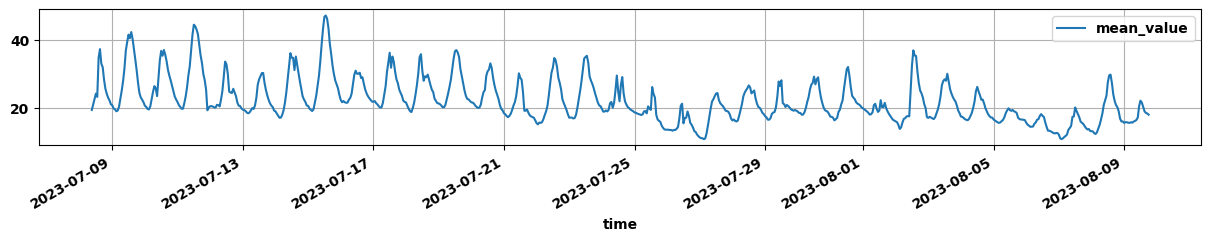

In [77]:
df.plot(figsize=(15,2), grid="both");

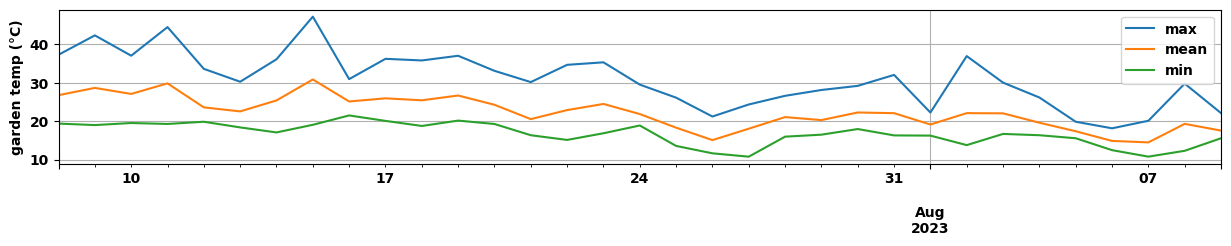

In [84]:
df["mean_value"].resample("1d").agg(["max", "mean", "min"]).plot(figsize=(15,2), grid="both", ylabel="garden temp (°C)", xlabel="");

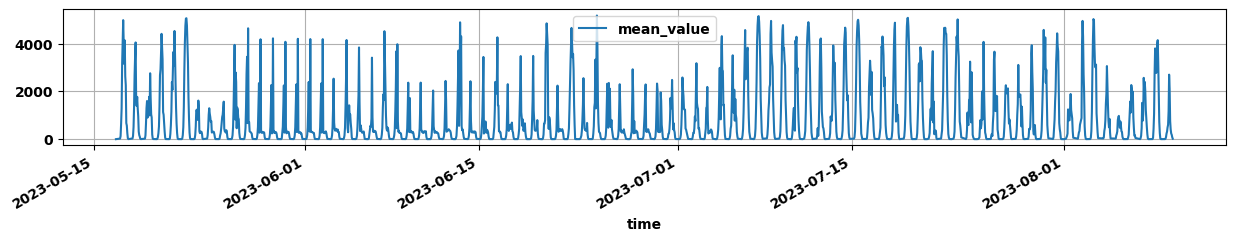

In [92]:
qstr = """SELECT mean_value FROM W WHERE entity_id='sma_pv_power_a'"""
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df.time = pd.to_datetime(df.time)
df = df.set_index("time")
df.plot(figsize=(15,2), grid="both");

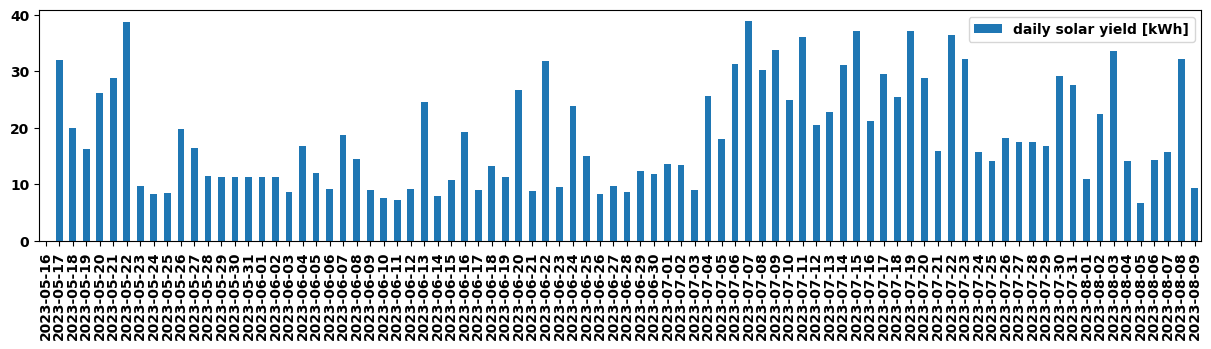

In [115]:
import datetime as dt
daily = df["mean_value"].resample("1d").agg(["sum"])
daily["sum"] = daily["sum"].values / 1000
daily.columns = ["daily solar yield [kWh]"]
daily["date"] = [dt.datetime.date(ts) for ts in daily.index]
daily = daily.set_index("date")
daily.plot(kind="bar", figsize=(15,3), xlabel="");